# IPD et Machine learning

Auteur : Philippe Mathieu, CRISTAL Lab, SMAC Team, University of Lille, email : philippe.mathieu@univ-lille.fr

Contributeurs : Louisa Fodil (CRISTAL/SMAC), Céline Petitpré (CRISTAL/SMAC)

Creation : 18/01/2018

## Introduction

Le Dilemme itéré du prisonnier permet d'exprimer une infinité de stratégies. Il est naturel de se demander laquelle est la meilleure ? Malheureusement il n'y a pas de stratégie meilleure dans l'absolu. On ne peut par exemple pas jouer optimalement contre `All_D` et `Spiteful`. Ceci est du au fait qu'il s'agit d'un jeu simultané, et qu'au premier coup, on ne connait pas encore son adversaire. Il faut donc choisir. Il y a par contre des stratégie plus "robustes" que d'autres, au sens où elles sont toujours efficaces dans des environnements variés.
Les compétitions écologiques et les sous-classes sont des moyens de faire varier légèrement l'environnement.
Reste maintenant à trouver de bonnes stratégies.
Nous cherchons ici à savoir quels sont les outils qui nous permettent d'identifier de nouvelles stratégies robustes et notamment si les techniques d'Intelligence Artificielle peuvent nous être utiles pour les mettre en évidence.

Dans ce notebook nous considérons comme acquis tous les outils précédemment créés.

The matrix of scores of the tournament : 
         per_D  per_DDC  per_CCD  per_C  Total
per_D       10       22       38     50    120
per_DDC      7       16       35     44    102
per_CCD      3       15       24     36     78
per_C        0        9       21     30     60
One (if many) of the winner of the tournament: 
per_D
Population evolution of the ecological competition : 


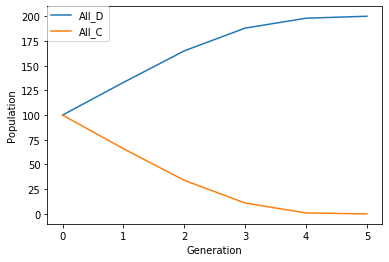

One (if many) of the winner of the ecological competition : 
All_D    200
Name: 5, dtype: object


In [1]:
# All about simultaneous games (class Game with getNash(), getPareto(), getDominantStrategies())
%run ../src/game.py

# All about ipd (Meeting, Tournament and Ecological classes)
%matplotlib inline
%run ../src/ipd.py

# All about strategies (getPeriodics(n), getMem(X,Y), getClassicals())
%run ../src/strategies.py

# How to use these modules ?

# We focus here on the iterated prisoner's dilemma Game
dip =[(3,3),(0,5),(5,0),(1,1)]
g = game.Game(dip,['C','D'])

# A tournament
bag = []
bag.append(Periodic('C'))
bag.append(Periodic('D'))
bag.append(Periodic('DDC'))
bag.append(Periodic('CCD'))
t=Tournament(g,bag,10)
t.run()
print("The matrix of scores of the tournament : ")
print(t.matrix)
print("One (if many) of the winner of the tournament: ")
print(list(t.matrix.columns)[0])


# An ecological competition
eco = Ecological(g, [Periodic("C","All_C"), Periodic("D","All_D")])
eco.run()
print("Population evolution of the ecological competition : ")
eco.drawPlot()
print("One (if many) of the winner of the ecological competition : ")
print(eco.historic.iloc[-1][0:1])

# Methode de Monte-Carlo

## Battre une classe mem
Il est très souvent (toujours ?) possible de trouver une stratégie capable de battre toutes celles d'une classe donnée dans une classe d'ordre supérieur. Par exemple trouver une `Mem(2,2)` capable de gagner dans l'ensemble des `Mem(1,1)`. La manière la plus simple d'en trouver une consiste à calculer un certain nombre de fois un génotype aléatoire d'une `Mem(2,2)`, de l'évaluer dans `Mem(1,1)`, de regarder son classement et de ne la conserver que si c'est la meilleure actuellement connue. C'est ce que l'on appelle une méthode de Monté-Carlo car elle teste des stratégies par pur hasard, comme à la roulette. 
Ce genre de méthode permet néanmoins d'en trouver comme par exemple `Mem(2,2,'CCCCDDDCCDCDDDDDDD')`.

In [ ]:
class FindBest:
    def __init__(self, game):
        self.game = game

    def generate_random_genotype(self, x, y):
        """
        Generates a random genotype from Mem(x,y)
        """
        N = max(x, y) + 2 ** (x + y)
        genotype = ""
        for i in range(N):
            genotype += random.choice(self.game.actions)
        return genotype

    def random_selection(self, x, y, nb_tests, bag):
        """
        Does nb_tests ecological competitions against bag with each time a random genotype from Mem(x,y) 
        Returns a sorted list of the genotypes based on their rank in the ecological competition
        """
        d = dict()
        for n in range(nb_tests):
            genotype = self.generate_random_genotype(x, y)
            strat = Mem(x, y, genotype)
            eco = Ecological(self.game, bag + [strat])
            eco.run()
            d[genotype] = eco.historic.columns.tolist().index(strat.name)
        return sorted(d.items(), key=lambda t: t[1])


gen = FindBest(g)
bag = getMem(1, 1)
# Prints the two best genotypes frome the Mem(2,2) against bage and after 10 executions
print(gen.random_selection(2, 2, 10, bag)[1:3])

### Evaluation de la stratégie trouvée précédemment

In [ ]:
bag3 = getMem(1, 1)
e2 = Ecological(g, bag3 + [Mem(2, 2, "CCCCDDDCCDCDDDDDDD")])
e2.run()
e2.drawPlot(None, 4)
evol = e2.historic
print(evol.iloc[-1][evol.iloc[-1] > 0])

## Algo Génétique

Les techniques de Monte-Carlo sont simples à comprendre mais lentes à converger. Les algorithmes génétiques sont bien plus performants pour ce type de recherche. Python offre pour ce type d'algorithme, des librairies assez performantes. C'est le cas de la librairie [Deap](https://deap.readthedocs.io/en/master/).

Un algo génétique a pour objectif de trouver un bon génotype dans un ensemble des phénotypes possible. Il démarre initialement d'une liste de taille fixée, d'individus pris au hasard. Il effectue plusieurs tours de calculs à partir de cette liste. A chaque tour, il élimine de la liste les individus les plus mauvais calculés selon une fonction de fitness  qu'il faut préciser( ici `evaluateInd`). Il complète alors sa liste avec de nouveaux individus obtenus à l'aide de deux opérations élémentaires : la mutation qu'il faut aussi préciser ici (`myMutation`) et le crossing over (`cxTwoPoint` (déjà définie dans deap)) pour toujours avoir une liste de même taille.

Ci dessous nous définissons une classe Genetic qui s'appuie sur Deap et qui définit la Mutation sur des génotypes de type `mem(x,y)`. On définit aussi notre propre fonction de fitness basée sur le résultat du classement de la stratégie dans june compétition écologique.

Par la suite, on prend une population `pop` = 25; le nombre de parents gardé à chaque itération `parents` = 18; le nombre d'enfants produits `children` =  7; le taux de crossover `cxpb` = 0.8 et le taux de mutation `mutpb` = 0.015.


In [12]:
import math
from deap import creator, base, tools, algorithms
import random
import time


class Genetic:
    def __init__(self, game, x, y, bag, option="tournament", length=100):
        self.game = game
        self.x = x
        self.y = y
        self.bag = bag
        self.option = option
        self.length = length

    def createEnv(self):
        creator.create(
            "FitnessMax", base.Fitness, weights=(-1.0,)
        )  # -1.0 in order to minimize , 1.0 to maximize
        creator.create("Individual", list, fitness=creator.FitnessMax)
        toolbox = base.Toolbox()
        toolbox.register("random_action", random.choice, "CD")
        DIM = max(self.x, self.y) + 2 ** (self.x + self.y)
        toolbox.register(
            "individual",
            tools.initRepeat,
            creator.Individual,
            toolbox.random_action,
            n=DIM,
        )
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("select", tools.selBest)
        if self.option == "tournament":
            toolbox.register("evaluate", self.evaluateIndTournament)
        elif self.option == "ecological":
            toolbox.register("evaluate", self.evaluateIndEcological)
        toolbox.register("mutate", self.myMutation)
        return toolbox

    def runEvolutionnary(self, toolbox, pop, parents, children, cxpb, mutpb):
        """
        pop : number of individuals in the population 
        parents : The number of individuals to select for the next generation.
        children : The number of children to produce at each generation.
        cxpb : The probability that an offspring is produced by crossover.
        mutpb : The probability that an offspring is produced by mutation.
        """
        # The number of generation.
        ngen = 1
        pop = toolbox.population(n=pop)
        fit = math.inf
        # The algo stops when one individual becomes first in the ranking
        while fit > 1:
            algorithms.eaMuPlusLambda(
                pop, toolbox, parents, children, cxpb, mutpb, ngen, verbose=False
            )
            top = sorted(pop, key=lambda x: x.fitness.values[0])[-1]
            fit = top.fitness.values[0]
            print(
                "Ranking of the best strategy ["
                + self.__str__(top)
                + "] : "
                + str(int(fit))
            )
        print("Winning strategy : " + self.__str__(top))
        return self.__str__(top)

    def __str__(self, individual):
        s = ""
        for i in range(len(individual)):
            s += individual[i]
        return s

    def evaluateIndEcological(self, individual):
        """
        Evaluates an individual in an ecological competition
        """
        genotype = self.__str__(individual)
        strat = Mem(self.x, self.y, genotype)
        eco = Ecological(self.game, self.bag + [strat], length=self.length)
        eco.run()
        return (float(eco.historic.columns.tolist().index(strat.name) + 1),)

    def evaluateIndTournament(self, individual):
        """
        Evaluates an individual in a tournament
        """
        genotype = self.__str__(individual)
        strat = Mem(self.x, self.y, genotype)
        tournament = Tournament(self.game, self.bag + [strat], self.length)
        tournament.run()
        return (
            float(
                tournament.matrix["Total"]
                .tolist()
                .index(tournament.matrix["Total"][strat.name])
                + 1
            ),
        )

    def myMutation(self, individual):
        """
        Mutates an individual in one random place
        """
        i = random.randint(0, len(individual) - 1)
        if individual[i] == "C":
            individual[i] = "D"
        else:
            individual[i] = "C"
        return (individual,)

## Les algorithmes génétiques appliquées aux compétitions écologiques

### Un exemple simple et rapide : trouver parmi Mem(1,2) une stratégie qui gagne contre le triplet (All_C, All_D, TFT) en compétition écologique 

In [6]:
bag = [Periodic("C"), Periodic("D"), Tft()]
gen = Genetic(g, 1, 2, bag, "ecological", 100)
toolbox = gen.createEnv()
t = time.time()
winner = gen.runEvolutionnary(toolbox, 25, 18, 7, 0.8, 0.015)
t2 = time.time()
print("Execution time : " + str(t2 - t) + " secondes")

Winning strategy : CDCCCCDCCD
Execution time : 7.530839204788208 secondes


#### On peut maintenant vérifier avec un graphe que la stratégie est bien gagnante

In [ ]:
e = Ecological(g, bag+[Mem(1,2,winner)], length = 100)
e.run()
e.drawPlot()

### Trouver la meilleure stratégie Mem(1,2) qui bat toutes les stratégies de Mem(1,1) (execution > 4H)
Par exemple Mem(1,2,"CCCCDDDDDD")

In [ ]:
bag = getMem(1,1)
gen = Genetic(g,1,2,bag, "ecological", 100)
toolbox = gen.createEnv()
t = time.time()
gen.runEvolutionnary(toolbox, 25, 18, 7, 0.8, 0.015)
t2 = time.time()
print("Execution time : " + str(t2-t) + " secondes")

In [ ]:
# Let's check the result which was CCCCDDDDDD
bag = getMem(1,1)
e = Ecological(g, bag+[Mem(1,2,"CCCCDDDDDD")], length = 100)
e.run()
e.drawPlot(None,4)

### Trouver la meilleure stratégie Mem(2,1) qui bat toutes les stratégies de Mem(1,1)(execution > 4H)

In [4]:
bag = getMem(1,1)
gen = Genetic(g,2,1,bag, "ecological", 100)
toolbox = gen.createEnv()
t = time.time()
gen.runEvolutionnary(toolbox, 25, 18, 7, 0.8, 0.015)
t2 = time.time()
print("Execution time : " + str(t2-t) + " secondes")

/home/m2mocad/petitprec/.local/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/m2mocad/petitprec/.local/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Ranking of the best strategy [DCCDCCCCCC] : 19
Ranking of the best strategy [DCDCCDDDCD] : 18
Ranking of the best strategy [CCDDCCDDDD] : 12
Ranking of the best strategy [CCDDCCDDDD] : 12
Ranking of the best strategy [DCCDCCDDCD] : 11
Ranking of the best strategy [DCCDDCDDDD] : 5
Ranking of the best strategy [CCCDCCDDDD] : 1
Winning strategy : CCCDCCDDDD
Execution time : 39.892335414886475 secondes


In [ ]:
# Let's check the result which was CCCDDDCDDD
bag = getMem(1,1)
e = Ecological(g, bag+[Mem(2,1,"CCCDDDCDDD")], 100)
e.run()
e.drawPlot(None,4)

### Trouver la meilleure stratégie Mem(2,2) qui bat toutes les stratégies de Mem(1,1)(execution > 24H)

In [5]:
bag = getMem(1,1)
gen = Genetic(g,2,2,bag, "ecological", 100)
toolbox = gen.createEnv()
t = time.time()
gen.runEvolutionnary(toolbox, 25, 18, 7, 0.8, 0.015)
t2 = time.time()
print("Execution time : " + str(t2-t) + " secondes")

Ranking of the best strategy [DDDCDCDDDCCCCCDCCD] : 19
Ranking of the best strategy [DDCCDDCCCDDDDDDCDC] : 16
Ranking of the best strategy [DDDCDDCCCDDCCDCDDC] : 13
Ranking of the best strategy [CDCCDDDDDDDCCDCDDC] : 13
Ranking of the best strategy [DDDDDDCDDDDCCDCDDC] : 13
Ranking of the best strategy [DDDCDDCCCDDCCCDDDD] : 12
Ranking of the best strategy [DCCDCDCCDDDCCDDDDD] : 5
Ranking of the best strategy [DCCDCDCCDDDCCDDDDD] : 5
Ranking of the best strategy [CDCCDDCCDDCCCDCDDD] : 5
Ranking of the best strategy [CDCCDDCCDDCCCDCDDD] : 5
Ranking of the best strategy [CCCDDCDDDCCCDDCCCC] : 5
Ranking of the best strategy [CCCDDCDDDCCCDDDCCD] : 5
Ranking of the best strategy [CDDDDDCDDDDCCDCCCD] : 5
Ranking of the best strategy [CCCDCCDDDDDCDDCDCC] : 5
Ranking of the best strategy [CCCCDCDDCCDDDDDCCD] : 5
Ranking of the best strategy [CCCCCDCDCCDDDDDCCD] : 4
Ranking of the best strategy [CCCCDDCCCDDDDDDCCD] : 3
Ranking of the best strategy [CCCCDDCCCDDDDDDCCD] : 3
Ranking of the best st

In [ ]:
# Let's check the result which was CCCCDDDDDCDDDDDDCD
bag = getMem(1,1)
e = Ecological(g, bag+[Mem(2,2,"CCCCDDDDDCDDDDDDCD")], 100)
e.run()
e.drawPlot(None,4)

### Trouver la meilleure stratégie Mem(3,1) qui bat toutes les stratégies de Mem(1,1)

In [8]:
bag = getMem(1,1)
gen = Genetic(g,3,1,bag, "ecological", 100)
toolbox = gen.createEnv()
t = time.time()
gen.runEvolutionnary(toolbox, 25, 18, 7, 0.8, 0.015)
t2 = time.time()
print("Execution time : " + str(t2-t) + " secondes")

Ranking of the best strategy [CDDDDCCDDCDDDCCDDCD] : 16
Ranking of the best strategy [DDCCDDCDCDDCCCDCCCD] : 16
Ranking of the best strategy [DDDDCCDCDCCDCCCDCDC] : 14
Ranking of the best strategy [CDDDCDDCDDDDCDDCDDC] : 13
Ranking of the best strategy [CDDCDCDCCDDCCDDDDCD] : 13
Ranking of the best strategy [CDDDCDDCDDDDCDDCDDD] : 13
Ranking of the best strategy [DDDDDCDCDDDCCCCCDDD] : 12
Ranking of the best strategy [DDDDCDDCCCDCDCCCDDD] : 12
Ranking of the best strategy [DDDDDCDCDDDCCCCCDDD] : 12
Ranking of the best strategy [CCCCDDDCCDDCCDDDDDC] : 5
Ranking of the best strategy [CCCCDCDCCDDDCDDDDCD] : 5
Ranking of the best strategy [CCCCDDDCCDDCCDDDDDC] : 5
Ranking of the best strategy [CCCCDCDCCCCCDDCDDDC] : 3
Ranking of the best strategy [CCCCDCDCCCCCDDCDDDC] : 3
Ranking of the best strategy [CCCCDCDCCCCCDDCDDDC] : 3
Ranking of the best strategy [CCCCDCDCCCCCDDCDDDC] : 3
Ranking of the best strategy [CCCCDCDCCCCCDDCDDDC] : 3
Ranking of the best strategy [CCCCDCDCCCCCDDCDDDC] : 3
R

Ranking of the best strategy [CCCCDCDCCCCCDDCDDDD] : 2
Ranking of the best strategy [CCCCDCDCCCCCDDCDDDD] : 2
Ranking of the best strategy [CCCCDCDCCCCCDDCDDDD] : 2
Ranking of the best strategy [CCCCDCDCCCCCDDCDDDD] : 2
Ranking of the best strategy [CCCCDCDCCCCCDDCDDDD] : 2
Ranking of the best strategy [CCCCDCDCCCCCDDCDDDD] : 2
Ranking of the best strategy [CCCCDCDCCCCCDDCDDDD] : 2
Ranking of the best strategy [CCCCDCDCCCCCDDCDDDD] : 2
Ranking of the best strategy [CCCCDCDCCCCCDDCDDDD] : 2
Ranking of the best strategy [CCCCDCDCCCCCDDCDDDD] : 2
Ranking of the best strategy [CCCCDCDCCCCCDDCDDDD] : 2
Ranking of the best strategy [CCCCDCDCCCCCDDCDDDD] : 2
Ranking of the best strategy [CCCCDCDCCCCCDDCDDDD] : 2
Ranking of the best strategy [CCCCDCDCCCCCDDCDDDD] : 2
Ranking of the best strategy [CCCCDCDCCCCCDDCDDDD] : 2
Ranking of the best strategy [CCCCDCDCCCCCDDCDDDD] : 2
Ranking of the best strategy [CCCCDCDCCCCCDDCDDDD] : 2
Ranking of the best strategy [CCCCDCDCCCCCDDCDDDD] : 2
Ranking of

### Trouver la meilleure stratégie Mem(2,3) qui bat toutes les stratégies de Mem(1,1)

In [14]:
bag = getMem(1,1)
gen = Genetic(g,2,3,bag, "ecological", 100)
toolbox = gen.createEnv()
t = time.time()
gen.runEvolutionnary(toolbox, 25, 18, 7, 0.8, 0.015)
t2 = time.time()
print("Execution time : " + str(t2-t) + " secondes")

Ranking of the best strategy [CCDCDDDDCCDCDDCDCDDDCCCDDCCCCCDCCDC] : 20
Ranking of the best strategy [DCCDDDDDDDDCCCCCCDDCDDCCCCCCCCDCDCD] : 19
Ranking of the best strategy [CCCDCDCDDCDCCCDDDDCCCDDDDDCCCDDCDDC] : 19
Ranking of the best strategy [DCCCDDCDDDDCDCDCCCCDDDCCCDCCDDCCDCC] : 19
Ranking of the best strategy [CDCCCCDDCDCDDDDCDDCDDCDCDDCCDDDCCDC] : 19
Ranking of the best strategy [DDDCCDDCDDDCCDDDCDDCDDCCCCCCCCDCDCD] : 18
Ranking of the best strategy [DDDDDCDDDDDCCDDDCDDCDDCCCCCCCCDDDDD] : 16
Ranking of the best strategy [CDDDCCDCDDDDCDDDDDDCDDCDDDCCCDDCDDC] : 14
Ranking of the best strategy [DDDDCCDDDDDCCDDDCDDDDDCDDDCCCDDDDDD] : 13
Ranking of the best strategy [DDDDCCDCDDDCCDDDCDDDDDCCDDCDCDDDDDD] : 13
Ranking of the best strategy [DDDDCCDCDDDDCDDDDDDCDDCCDDCCDDDDDDD] : 13
Ranking of the best strategy [DDDDCCDCDDDDCDDDDDCCDDCCDDDDDDDDDDD] : 12
Ranking of the best strategy [CCCCDCDDDCCDCDDDDDDCCDCCCCDDDCDCCCD] : 5
Ranking of the best strategy [CCCCDCDDDCCDCDDDDDDCCDCCCCDDDCDCCCD

### Trouver la meilleure stratégie Mem(3,3) qui bat toutes les stratégies de Mem(1,1)(Test)

In [ ]:
bag = getMem(1,1)
gen = Genetic(g,3,3,bag, "ecological", 100)
toolbox = gen.createEnv()
t = time.time()
gen.runEvolutionnary(toolbox, 25, 18, 7, 0.8, 0.015)
t2 = time.time()
print("Execution time : " + str(t2-t) + " secondes")

Ranking of the best strategy [DDDCDDDCCCCDCCDDDCDDDCDDCDDCCCCCDDDCDCDCDCCCCCCCCDCCDCCCCDCCDCCDDCC] : 19
Ranking of the best strategy [DDDCDDDCCCCDCCDDDCDDDCDDCDDCCCCCDDDCDCDCDCCCCCCCCDCCDCCCCDCCDCCDDCC] : 19
Ranking of the best strategy [DCDDDCCDCDDDCDCDDDDCDDDDDCCDCCCCCDCDCDDCDDDDCDDDCDCCDCDDDCCDDDDDDDD] : 19
Ranking of the best strategy [CDCDDDCDCCCDCCDDDDDDDCCCDDCCCDDCDCCCCDCCDDCCCDDCCDCDDCCCCCDDDDDCDCD] : 19
Ranking of the best strategy [DDCDDCDCCCDDCDDCDDCDCCCDDCDCCDCDCCDCCDCDDDCCDDCDCCDDCCCCCDCCDDDDCDC] : 18
Ranking of the best strategy [DDCDDCDDCCCDCDDCCDCCCDCDCDDDCDCDCDDCDCCCCCCCCCDDDDDDDCDCCDDDCCCCCDD] : 16
Ranking of the best strategy [DCCCDDCCCDCDCDCCDDDCDDCDDDCDDDCDDDDCDDDDDDDCDDCDCCDDCDDCDDCCDCDCDCC] : 14
Ranking of the best strategy [DCDDDCCDCDDDDCCDDDDDDCDDCDDDDDCCCDCDCDDCDDDDCDDDCDCCDCDDCDDCDDDDDDD] : 13
Ranking of the best strategy [DCDDDCCDCDDDDCCDCDDDDDDCCCDDDDCCCDCDCDDCDDDDCDDDCDCCDCDDCDDCDDDDDDD] : 13
Ranking of the best strategy [DDCDDCDDCCCDCDDCCDCDDDDCCCDDDDCCCD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC] : 2
Ranking of the best strategy [CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDD

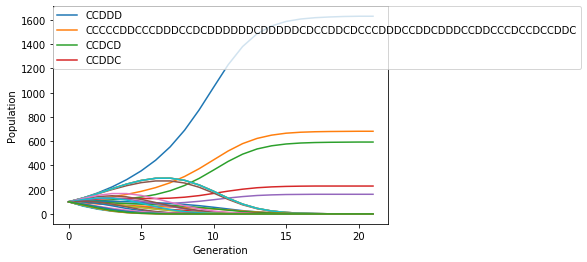

In [3]:
# After 14 hours we get a strategy that is second
bag = getMem(1,1)
e = Ecological(g, bag+[Mem(3,3,"CCCCCDDCCCDDDCCDCDDDDDDCDDDDDCDCCDDCDCCCDDDCCDDCDDDCCDDCCCDCCDCCDDC")], 100)
e.run()
e.drawPlot(None,4)

Encore une fois les stratégies trouvées pour surperformer contre une classe donnée sont particulièrement bien adaptées à cette classe mais très peu robustes. En changeant ne serait-ce qu'une stratégie dans l'ensemble initiale, elles ne surperforment plus.
On étudie ici une stratégie obtenue par algorithme génétique face à toutes les sous-classes de taille (n-1)

In [ ]:
# Let's try to fing a Mem(1,1) strategy who wins against multiple other strategies in a bag
bag = [Periodic("C"),Periodic("D"), SoftMajority(), HardMajority(), Periodic("DDC"), Periodic("DDCD")]
gen = Genetic(g,1,1,bag, "ecological", 100)
toolbox = gen.createEnv()
gen.runEvolutionnary(toolbox, 25, 18, 7, 0.8, 0.015)


In [ ]:
# Now, let's evaluate this strategy against all the subclasses of the bag 
res = subClassesWithOneStrat(bag, 2, Mem(1,1,winner), length = 100)

On voit ici que la stratégie gagnante a une pire place égale à 3, ce qui montre bien qu'elle ne gagne pas tout le temps.
On a fait de l'"overfitting". 

## Les algorithmes génétiques appliquées aux tournois
Les tournois permettent d'avoir des résultats beaucoup plus rapidement qu'avec les compétitions écologiques

### Trouver la meilleure stratégie Mem(1,2) qui bat toutes les stratégies de Mem(1,1)

In [ ]:
bag = getMem(1,1)
gen = Genetic(g,1,2,bag, "tournament", 100)
toolbox = gen.createEnv()
t = time.time()
gen.runEvolutionnary(toolbox, 25, 18, 7, 0.8, 0.015)
t2 = time.time()
print("Execution time : " + str(t2-t) + " secondes")

### Trouver la meilleure stratégie Mem(2,1) qui bat toutes les stratégies de Mem(1,1)

In [ ]:
bag = getMem(1,1)
gen = Genetic(g,2,1,bag, "tournament", 10)
toolbox = gen.createEnv()
t = time.time()
gen.runEvolutionnary(toolbox, 25, 18, 7, 0.8, 0.015)
t2 = time.time()
print("Execution time : " + str(t2-t) + " secondes")

### Trouver la meilleure stratégie Mem(2,2) qui bat toutes les stratégies de Mem(1,1)

In [ ]:
bag = getMem(1,1)
gen = Genetic(g,2,2,bag, "tournament", 10)
toolbox = gen.createEnv()
winner = gen.runEvolutionnary(toolbox, 25, 18, 7, 0.8, 0.015)

### Trouver la meilleure stratégie Mem(3,3) qui bat toutes les stratégies de Mem(1,1)

In [ ]:
bag = getMem(1,1)
gen = Genetic(g,3,3,bag, "tournament", 10)
toolbox = gen.createEnv()
winner = gen.runEvolutionnary(toolbox, 25, 18, 7, 0.8, 0.015)

On peut vérifier que cette stratégie est bien gagnante dans un tournoi avec les Mem(1,1)

In [ ]:
t=Tournament(g,bag+[Mem(3,3,winner)],10)
t.run()
print("The matrix of the tournament: ")
print(t.matrix['Total'])

## Approche neuronale (Caffe ? TensorFlow ? Keras ?)

# Bibliographie

- Robert Axelrod, The Evolution of Cooperation (New York: Basic Books, 1984).
- JP Delahaye et P Mathieu. Des surprises dans le monde de la coopération. Pour la Science, numéro spécial "Les mathématiques sociales", pp 58-66, Juillet 1999.
- Philippe Mathieu, Jean-Paul Delahaye. [New Winning Strategies for the Iterated Prisoner's Dilemma](http://jasss.soc.surrey.ac.uk/20/4/12.html). J. Artificial Societies and Social Simulation 20(4) (2017)
- Philippe Mathieu, Jean-Paul Delahaye. New Winning Strategies for the Iterated Prisoner's Dilemma. AAMAS 2015: 1665-1666
- Bruno Beaufils, Jean-Paul Delahaye et Philippe Mathieu. Our Meeting with Gradual : A good Strategy for the Itareted Prisoner’s Dilemma, in Intern. Cof. on Artificial Life V (ALIFE V), pp. 159- 165, 16-18 mai 1996, Nara (Japon).
- Martin Nowak et K. Sigmund, TIT for TAT in Heterogeneous Populations, Nature, vol. 355, n° 16, pp. 250-253, janvier 1992.